In [2]:
'''%matplotlib widget
'''
import os
import numpy as np
import pandas as pd
import random
import warnings
from __future__ import division
# import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.stats import norm
from scipy.stats import linregress
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection    
from statistics import mode

import random
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pickle
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
class LayerInstance():
    r""""
    
    Creates a layer simulation instance which runs with the execute function.
    
    Args:
        args: 
        kwargs: (unused)

    Shape:
        .csv file of nxm point space

    Examples::

        >>> instance = LayerInstance()
        >>>
    
    """
    def __init__(self,  defect_parameters = {  'Class': [0, 1, 2, 3, 4, 5],
                                                # 'Probability': [2, 0.015/8, 0.015/8, 0.01/8, 0.005/8, 0.005/8],
                                                'Probability': [1, 0.0001, 0, 0, 0, 0],
                                                'Sigma_xx': [0, 1, 1, 1, 1, 1],
                                                'Sigma_yy': [0, 1, 1, 1, 1, 1],
                                                'Sigma_xy': [0, 1, 1, 1, 1, 1],
                                                'Sigma_yx': [0, 1, 1, 1, 1, 1]}, 
                        observation_chance = 0.91, 
                        map_number = 1, 
                        map_location = 'maps/',
                        map_name = 'map_',
                        checkpoint_location = 'checkpoints/',
                        regen = False):
        
        self.map_number = map_number
        self.seed = np.random.randint(0, 100) # Pick a random seed
        self.defect_parameters = defect_parameters
        self.observation_chance = observation_chance
        self.checkpoint_location = checkpoint_location


        # Initializing the layer and generating the relevant data
        print("Initialized layer ", map_number, " with seed ", self.seed)

        path_exist = os.path.exists(map_location)
        if not path_exist:
            print("DirectoryError: Directory not found")

        loaded = 0
        try: # Try to load previous data
            self.raw_map = pickle.load(open(map_location + map_name + str(map_number)+ '.pkl', 'rb')) # Map of all points
            print("Loaded raw map")
            loaded += 1
            self.card_1 = pickle.load(open(map_location + 'cardinal_maps/arm1_cardinal_map_' + str(map_number)+ '.pkl', 'rb')) # Cardinal map
            self.card_2 = pickle.load(open(map_location + 'cardinal_maps/arm2_cardinal_map_' + str(map_number)+ '.pkl', 'rb')) 
            print("Loaded cardinal maps")
            loaded += 1

            # Loading txt files
            #self.map_classed = self.load_dict(checkpoint_location + 'map_classed_observed_' + str(map_number) + '.txt') # Map classed w/ observations
            self.map_classed = pickle.load(open(self.checkpoint_location + 'map_classed_observed_' + str(self.map_number) + '.pkl', 'rb'))
            print("Loaded classed map")
            loaded += 1
            #self.map_classed_max = self.load_dict(checkpoint_location +'output_map_observed_max_' + str(map_number) + '.txt') # Map w/ only max class
            self.map_classed_max = pickle.load(open(self.checkpoint_location +'output_map_observed_max_' + str(self.map_number) + '.pkl', 'rb'))
            print("Loaded max class map")
            loaded += 1
            self.map_downsampled = np.loadtxt(self.checkpoint_location + "downsampled_map_" + str(self.map_number) + " .txt", delimiter=",") # Downsampled map
            print("Loaded downscaled map")
            loaded += 1
            self.map_downsampled_observations = np.loadtxt(self.checkpoint_location + "downsampled_map_observation_ratio" + str(self.map_number) + " .txt", delimiter=",") # Downsampled map
            print("Loaded downscaled map observation ratios")
            loaded += 1
            self.map_downsampled_real = np.loadtxt(self.checkpoint_location + "downsampled_map_real_" + str(self.map_number) + " .txt", delimiter=",")
            print("Loaded downscaled map observation ratios")
            loaded += 1
            
            print('Checkpoint loaded!') # All data has successfully been loaded

        except: # If loading failed
            if loaded == 0: # Wrong map called
                print('Instance creation failed: map ', map_location + str(map_number) + '.pkl', 'not found')
            else: # Some checkpoint failed
                if loaded == 2: # Must be new map
                    print('No previous data found, generating data...')
                else: # Old map, regenerating anyways
                    print('Failed to load at checkpoint ', str(loaded + 1), '/ 7')
                    print('Regenerating data...')

                # Generating the data
                
                self.map_classed = self.generate_map_defects_from_card()
                print('Generated part with ', self.extruded_points, ' extruded points and ', self.defect_total, ' total defects')

                print('Observing part...')
                self.map_classed_max = self.observe_map_from_card()
                print('Observed part with ', self.obs_defects, '/', self.defect_total, ' defects')
                print('Downsampling map...')
                self.map_downsampled, self.map_downsampled_observations, self.map_downsampled_real = self.downsample_map()


        if self.test_data():
            print('Instance successfully loaded!')
        else:
            print('VerificationError: data improperly loaded')

        

    def test_data(self):
        """
        Validates loaded data to ensure proper map creation

        parameters verified:
        self.map_classed
        self.map_classed_max
        self.map_downsampled

        returns:
        test state
        """
        result = True

        return result

    def test_data_loading(self):
        """
        Validates checkpoint data vs. generated data to ensure they are consistent

        parameters verified:
        self.map_classed
        self.map_classed_max
        self.map_downsampled

        returns:
        test state
        """

        self.loaded_map_classed = pickle.load(open(self.checkpoint_location + 'map_classed_observed_' + str(self.map_number) + '.pkl', 'rb')) # Map classed w/ observations
        if self.map_classed == self.loaded_map_classed:
            print("map_classed passed")
        else:
            print("map_classed failed")
        
        self.load_map_classed_max = self.map_classed_max = pickle.load(open(self.checkpoint_location +'output_map_observed_max_' + str(self.map_number) + '.pkl', 'rb')) # Map w/ only max class
        if self.map_classed_max == self.load_map_classed_max:
            print("map_classed_max passed")
        else:
            print("map_classed_max failed")
        

        self.load_map_downsampled = np.loadtxt(self.checkpoint_location + "downsampled_map_" + str(self.map_number) + " .txt", delimiter=",") # Downsampled map
        if self.map_downsampled.all() == self.load_map_downsampled.all():
            print("map_downsampled passed")
        else:
            print("map_downsampled failed")

        self.load_map_downsampled_observations = np.loadtxt(self.checkpoint_location + "downsampled_map_observation_ratio" + str(self.map_number) + " .txt", delimiter=",") # Downsampled map
        if self.map_downsampled_observations.all() == self.load_map_downsampled_observations.all():
            print("map_downsampled_observations passed")
        else:
            print("map_downsampled_observations failed")

        self.load_map_downsampled_real = np.loadtxt(self.checkpoint_location + "downsampled_map_real_" + str(self.map_number) + " .txt", delimiter=",")
        if self.map_downsampled_real.all() == self.load_map_downsampled_real.all():
            print("map_downsampled_real passed")
        else:
            print("map_downsampled_real failed")


        return 

    def load_dict(self, file_location):
        """
        Loads txt data into dictionaries for checkpoints
        """
        with open(file_location, 'r') as file:
            lines = [line.strip() for line in file.readlines()]

            # create an empty dictionary
            dictionary = {}

            # loop through the lines and split on the delimiter
            for line in lines:
                key, value = line.split(':')

                # add the key-value pair to the dictionary
                dictionary[key.strip()] = value.strip()

        return dictionary

    def generate_map_defects(self):
        """
        Creates a dictionary from the raw map which contains only extruded
        points with an assigned class from the defect parameters
        """

        map_data = self.raw_map

        defect_total = 0 
        extruded_points = 0
        persist = 0
        persist_class = 0
        for coord, state in dict(self.raw_map).items():
            if state != None:
                if persist > 0:
                    persist -= 1
                    self.raw_map[coord] = list(state) + [persist_class, 0, 0, 0, 0, 0, 0]
                else:
                    extruded_points += 1
                    defect_class = random.choices(self.defect_parameters['Class'], self.defect_parameters['Probability'])

                    if defect_class[0] != 0:
                        defect_total += 1
                        persist = 5
                        persist_class = defect_class[0]
                        #print(persist_class)
                        #print('defect generated of class', defect_class)

                    self.raw_map[coord] = list(state) + [defect_class[0], 0, 0, 0, 0, 0, 0]
            else:
                del self.raw_map[coord]

        with open('checkpoints/map_classed_' + str(self.map_number) + '.txt', 'w') as f:
            for key, value in self.raw_map.items():
                f.write(f'{key}: {value}\n')

        self.extruded_points = extruded_points
        self.defect_total = defect_total
        # print(extruded_points, defect_total)
        return map_data

    def generate_map_defects_from_card(self):
        """
        Generates defects from the cardinal maps to retain cardinality.
        
        Returns dictionary with 
        """
        ref_map = self.raw_map.copy()
        map_data = self.raw_map.copy()

        defect_total = 0 
        extruded_points = 0

        iter = 0
        for card_map in [self.card_1, self.card_2]:
            persist = 0
            persist_class = 0
            for num, coord in dict(card_map).items():
                state = ref_map[coord]
                if state != None:
                    if state[1] == 'G1':
                        # print('Is G1')
                        if persist > 0:
                            persist -= 1
                            map_data[coord] = list(state) + [persist_class, 0, 0, 0, 0, 0, 0]
                        else:
                            extruded_points += 1
                            defect_class = random.choices(self.defect_parameters['Class'], self.defect_parameters['Probability'])
                            # if iter == 90000:
                            #     defect_class = [2]
                            #     print('passed class 2!')

                            # if defect_class[0] == 5:
                            #     print('class 5!')
                            if defect_class[0] != 0:
                                defect_total += 1
                                persist = 5
                                persist_class = defect_class[0]
                                #print(persist_class)
                                # print('defect generated of class', defect_class)
                            iter += 1
                            map_data[coord] = list(state) + [defect_class[0], 0, 0, 0, 0, 0, 0]
                    else:
                        try:
                            del map_data[coord]
                        except:
                            pass
                else:
                    try:
                        del map_data[coord]
                    except:
                        pass


        # Clean dictionary
        for coord, state in dict(map_data).items():
            if state == None:
                del map_data[coord]

    

        with open('map_classed_' + str(self.map_number) + '.txt', 'w') as f:
            for key, value in map_data.items():
                f.write(f'{key}: {value}\n')

        # print(extruded_points, defect_total)
        self.extruded_points = extruded_points
        self.defect_total = defect_total
        return map_data

    def observe_map_from_raw(self):
        """
        Observes the map_classed with some chance of success from the raw map. Observed class of some coord
        is then stored in the values of that coord.

        Then for each coord, assign the observed class as the class that point was most
        frequently observed as and store as map_classed_max.

        Appends to map_classed
        Returns the map_classed_max
        """

        bound = np.zeros(shape=(380, 190))
        bound_obs = np.zeros(shape=(380, 190))
        span = np.linspace(-5, 5, 11)[0:10]/10
        span_classed = np.zeros(shape=(11, 11))


        for coord, state in self.raw_map.items():
            span_x = span + coord[0]
            span_y = span + coord[1]
            for x in range(len(span_x)):
                    for y in range(len(span_y)):
                        # Try the key, if failed pass
                        try:
                            state = self.map_classed[(span_x[x], span_y[y])]
                            distance = np.sqrt((coord[0]-span_x[x])**2 + (coord[1]-span_y[y])**2)
                            val = random.random()
                            if val < self.observation_chance - (distance * (.28/.5)):
                                state_obs = state[2]
                            else:
                                state_obs = random.choices(self.defect_parameters['Class'])[0]
                            self.map_classed[(span_x[x], span_y[y])][3 + state_obs] += 1
                        except:
                            pass

        with open('checkpoints/map_classed_observed_' + str(self.map_number) + '.txt', 'w') as f:
            for key, value in self.map_classed.items():
                f.write(f'{key}: {value}\n')

        # Declare the observed class
        map_observed_max = {}
        for coord, state in self.map_classed.items():
            max_index = 3 + state[3:9].index(max(state[3:9]))
            map_observed_max[coord] = max_index - 3

        with open('checkpoints/map_classed_observed_max_' + str(self.map_number) + '.txt', 'w') as f:
            for key, value in map_observed_max.items():
                f.write(f'{key}: {value}\n')

        return map_observed_max

    def observe_map_from_card(self):
        """
        Observes the map_classed with some chance of success from the cardinal maps. Observed class of some coord
        is then stored in the values of that coord.

        Then for each coord, assign the observed class as the class that point was most
        frequently observed as and store as map_classed_max.

        Appends to map_classed
        Returns the map_classed_max
        """

        bound = np.zeros(shape=(380, 190))
        bound_obs = np.zeros(shape=(380, 190))
        span = np.linspace(-5, 5, 11)[0:10]/10
        span_classed = np.zeros(shape=(11, 11))

        fails_1 = 0
        for state, coord in self.card_1.items():
            span_x = span + coord[0]
            span_y = span + coord[1]
            for x in range(len(span_x)):
                    for y in range(len(span_y)):
                        # Try the key, if failed pass
                        try:
                            state = self.map_classed[(span_x[x], span_y[y])]
                            distance = np.sqrt((coord[0]-span_x[x])**2 + (coord[1]-span_y[y])**2)
                            val = random.random()
                            if val < self.observation_chance - (distance * (.28/.5)):
                                state_obs = state[2]
                            else:
                                state_obs = random.choices(self.defect_parameters['Class'])[0]
                            self.map_classed[(span_x[x], span_y[y])][3 + state_obs] += 1
                        except:
                            fails_1 +=1
                            pass
        
        fails_2 = 0
        for state, coord in self.card_2.items():
            span_x = span + coord[0]
            span_y = span + coord[1]
            for x in range(len(span_x)):
                    for y in range(len(span_y)):
                        # Try the key, if failed pass
                        try:
                            state = self.map_classed[(span_x[x], span_y[y])]
                            distance = np.sqrt((coord[0]-span_x[x])**2 + (coord[1]-span_y[y])**2)
                            val = random.random()
                            if val < self.observation_chance - (distance * (0/.5)):
                                state_obs = state[2]
                            else:
                                state_obs = random.choices(self.defect_parameters['Class'])[0]
                            self.map_classed[(span_x[x], span_y[y])][3 + state_obs] += 1
                        except:
                            fails_2 +=1
                            pass

        with open('checkpoints/map_classed_observed_' + str(self.map_number) + '.pkl', 'wb') as f:
            pickle.dump(self.map_classed, f, protocol=pickle.HIGHEST_PROTOCOL)

        self.obs_defects = 0
        map_observed_max = {}
        for coord, state in self.map_classed.items():
            max_index = 3 + state[3:9].index(max(state[3:9]))
            if max_index - 3 > 0:
                self.obs_defects += 1
            map_observed_max[coord] = max_index - 3

        with open('checkpoints/output_map_observed_max_' + str(self.map_number) + '.pkl', 'wb') as f:
            pickle.dump(map_observed_max, f, protocol=pickle.HIGHEST_PROTOCOL)

        #print('Fails: ', fails_1, fails_2)
        return map_observed_max

    def downsample_map_old(self):
        """
        Downsamples high res dictionary maps to nxm arrays.
        Downsamples the map_classed dictionary from observations
        and the real reference. Stores the observation ratios for
        the observed downsampled map.

        Returns:
        bounds
        bounds_obs
        bounds_real
        """
        bound = np.zeros(shape=(380, 190))
        bound_obs = np.zeros(shape=(380, 190))
        span = np.linspace(-5, 5, 11)[0:10]/10
        span_classed = np.zeros(shape=(10, 10))

        bound_real = bound.copy()

        observation_chance = .98
        count = 0

        real_defect_list = [] # Store all locations of the real defects
        for i in range(len(bound)): # Go through all downsampling reference points
            for j in range(len(bound[0])):
                span_classed = np.zeros(shape=(10, 10))
                span_real_classed = span_classed.copy()

                span_x = span + i
                span_y = span + j

                class_observations = np.zeros(shape=(6))
                real_classes = np.zeros(shape=(6))
                for x in range(len(span_x)):  # Go through all possible keys
                    for y in range(len(span_y)):
                        try: # Try the key, if failed pass
                            # Get the max obs. class for the span point and add it to the temp. span
                            span_classed[x][y] = self.map_classed_max[(span_x[x], span_y[y])]
                            class_observations += self.map_classed[(span_x[x], span_y[y])][3:9]

                            # Get the real class if it exists
                            real_defect_class = self.map_classed[(span_x[x], span_y[y])][2]
                            span_real_classed[x][y] = real_defect_class
                            # print(real_defect_class)
                            real_classes[int(real_defect_class)] += 1
                        except:
                            # print('failed with index', x, y)
                            span_classed[x][y] = -1
                            pass


                ######
                # Get the real downsampled map from span_real_classed
                downsampled_real_class = 0
                class_found = False
                for defect_class in range(len(self.defect_parameters["Class"])):    # For all possible defects
                    if class_found == False:                                        # If a real defect class hasn't been found
                        if real_classes[5-defect_class]/np.sum(real_classes) > 0.5: # If a defect class presence is > 0.5, downsample = defective
                            downsampled_real_class = 5-defect_class
                            class_found = True
                            real_defect_list.append([i, j])
                            
                bound_real[i][j] = downsampled_real_class
                if downsampled_real_class > 0:
                    print("Downsampled to defect", downsampled_real_class)
                    print(span_real_classed)
                    print("at index", i, j)
                    print('Recreated span:')
                    regenerated = self.generate_real_span(i, j)
                    print(regenerated)
                    print("^^^^^^^^^^^")
                
                check = False
                # if count % 100 == 0:
                #     print('------------------------------------')
                #     print(span_real_classed)
                #     print(real_classes)
                #     # check = True

                # Removing noisy defects
                for x in range(len(span_x)): # Go through each span_classed element
                    for y in range(len(span_y)):
                        try:
                            state = span_classed[x][y]
                            # print('found state', state)       
                            if state > 0: # Only check if that element is defective
                                if check:
                                    print('validating for state ', state, 'at index', x, y)
                                real_defect = 0
                                for ii in np.linspace(-1,1,3): # For each neighboring point
                                    for jj in np.linspace(-1,1,3):
                                        if ii == 0 and jj == 0: # Skip itsself
                                            pass
                                        else:
                                            try:
                                                # If the neighbor exists and is a defect, then the point we are checking
                                                # is a real defect
                                                if check:
                                                    print('trying to check neighbor: ', span_classed[x+int(ii)][y+int(jj)])
                                                if span_classed[x+int(ii)][y+int(jj)] >= state :
                                                    # print('real defect')
                                                    real_defect += 1
                                            except:
                                                pass

                                if real_defect == 0: # If there is no neighboring defect report change state to no defect
                                    span_classed[x][y] = 0
                                    # print('updated noisy defect')
                        except:
                            pass
                passed = 0
                try: # Take a look at the max value defect and record that as the defect class
                    #obs_max = max(obs)
                    # print('getting max')
                    if np.max(span_classed) < 0:
                        bound[i][j] = 0

                    else:
                        bound[i][j] = np.max(span_classed)
                        # print('sum ', np.sum(class_observations))
                        # print('index', bound[i][j])
                        # print('vals ', class_observations[int(bound[i][j])])
                        bound_obs[i][j] = class_observations[int(bound[i][j])] / np.sum(class_observations)
                    # bound_obs[i][j] = n
                    # if np.max(span_classed) != 0:
                    #     print(np.max(span_classed), 'at ', i, j)
                    #     continue
                except:
                    #passed += 1
                    bound[i][j] = None
                    bound_obs[i][j] = 0

                # if count % 100 == 0:
                #     print(span_classed)
                #     print('----')
                count += 1

                # print('passed', passed)
        
        np.savetxt(self.checkpoint_location + "downsampled_map_real_" + str(self.map_number) + " .txt", bound_real, fmt='%.10f', delimiter=",")
        np.savetxt(self.checkpoint_location + "downsampled_map_" + str(self.map_number) + " .txt", bound, fmt='%.10f', delimiter=",")
        np.savetxt(self.checkpoint_location + "downsampled_map_observation_ratio" + str(self.map_number) + " .txt", bound_obs, fmt='%.10f', delimiter=",")

        return bound, bound_obs, bound_real

    def downsample_map(self):
        """
        Downsamples high res dictionary maps to nxm arrays.
        Downsamples the map_classed dictionary from observations
        and the real reference. Stores the observation ratios for
        the observed downsampled map.

        Returns:
        bounds
        bounds_obs
        bounds_real
        """
        bound = np.zeros(shape=(380, 190))
        bound_obs = np.zeros(shape=(380, 190))
        span = np.linspace(-5, 5, 11)[0:10]/10
        span_classed = np.zeros(shape=(10, 10))

        bound_real = bound.copy()

        observation_chance = .98
        count = 0

        real_defect_list = [] # Store all locations of the real defects
        for i in range(len(bound)): # Go through all downsampling reference points
            for j in range(len(bound[0])):
                span_classed = np.zeros(shape=(10, 10))
                span_real_classed = span_classed.copy()

                span_x = span + i
                span_y = span + j

                class_observations = np.zeros(shape=(6))
                real_classes = np.zeros(shape=(6))
                for x in range(len(span_x)):  # Go through all possible keys
                    for y in range(len(span_y)):
                        try: # Try the key, if failed pass
                            # Get the max obs. class for the span point and add it to the temp. span
                            span_classed[x][y] = self.map_classed_max[(span_x[x], span_y[y])]
                            class_observations += self.map_classed[(span_x[x], span_y[y])][3:9]

                            # Get the real class if it exists
                            real_defect_class = self.map_classed[(span_x[x], span_y[y])][2]
                            span_real_classed[x][y] = real_defect_class
                            # print(real_defect_class)
                            real_classes[int(real_defect_class)] += 1
                        except:
                            # print('failed with index', x, y)
                            span_classed[x][y] = -1
                            pass
                
                class_observations

                ######
                # Get the real downsampled map from span_real_classed
                downsampled_real_class = 0
                class_found = False
                for defect_class in range(len(self.defect_parameters["Class"])):    # For all possible defects
                    if class_found == False:                                        # If a real defect class hasn't been found
                        if real_classes[5-defect_class]/np.sum(real_classes) > 0.5: # If a defect class presence is > 0.5, downsample = defective
                            downsampled_real_class = 5-defect_class
                            class_found = True
                            real_defect_list.append([i, j])

                # Get the observed downsampled map from class observations
                max_index = np.argmax(class_observations)
                if class_observations[max_index]/np.sum(class_observations) > 0.5:
                    bound[i][j] = max_index
                else:
                    bound[i][j] = 0
                    max_index = 0

                bound_obs[i][j] = class_observations[max_index] / np.sum(class_observations)
                
                            
                bound_real[i][j] = downsampled_real_class
                if downsampled_real_class > 0:
                    print("Downsampled to real defect", downsampled_real_class)
                    print(span_real_classed)
                    print("at index", i, j)
                    # print('Recreated span:')
                    # regenerated = self.generate_real_span(i, j)
                    # print(regenerated)
                    print("Downsampled to observed", max_index)
                    print("with class obs:", class_observations)
                    print("^^^^^^^^^^^")
                
                check = False
                # if count % 100 == 0:
                #     print('------------------------------------')
                #     print(span_real_classed)
                #     print(real_classes)
                #     # check = True

                max_index = np.argmax(class_observations)
                if max_index > 0:
                    if class_observations[max_index]/np.sum(max_index) > 0.4:
                        bound[i][j] = max_index
                    else:
                        bound[i][j] = 0
                        max_index = 0

                    bound_obs[i][j] = class_observations[max_index] / np.sum(class_observations)

                passed = 0

        np.savetxt(self.checkpoint_location + "downsampled_map_real_" + str(self.map_number) + " .txt", bound_real, fmt='%.10f', delimiter=",")
        np.savetxt(self.checkpoint_location + "downsampled_map_" + str(self.map_number) + " .txt", bound, fmt='%.10f', delimiter=",")
        np.savetxt(self.checkpoint_location + "downsampled_map_observation_ratio" + str(self.map_number) + " .txt", bound_obs, fmt='%.10f', delimiter=",")

        return bound, bound_obs, bound_real

    def multivariate_gaussian(self, pos, mu, Sigma):
        """Return the multivariate Gaussian distribution on array pos."""

        n = mu.shape[0]
        Sigma_det = np.linalg.det(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        N = np.sqrt((2*np.pi)**n * Sigma_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

        return np.exp(-fac / 2) / N

    def get_sigma(self):



        return

    def get_gd(self, test_type='greater', defect_class=0):

        Z_total = np.zeros_like(self.map_downsampled)
        defects = 0
        for i in range(len(self.map_downsampled)):
            for j in range(len(self.map_downsampled[0])):
                passed = False
                # Check the test type
                if test_type == 'greater':
                    if int(self.map_downsampled[i][j]) > defect_class:
                        mu = np.array([i, j])
                        passed = True
                elif test_type == 'equal':
                    if int(self.map_downsampled[i][j]) == defect_class:
                        mu = np.array([i, j])
                        passed = True
                else:
                    print("get_gdError: wrong test type specfified")
                
                if passed == True:
                ##Create the meshgrid
                #X, Y = np.meshgrid(np.linspace(0, 190, 190), np.linspace(0, 380, 380))
                    Y, X = np.meshgrid(np.linspace(0, 190, 190), np.linspace(0, 380, 380))
                    pos = np.empty(X.shape + (2,))
                    pos[:, :, 0] = X
                    pos[:, :, 1] = Y

                    Sigma = np.array([[self.defect_parameters['Sigma_xx'][int(self.map_downsampled[i][j])] , 0], [0,  self.defect_parameters['Sigma_yy'][int(self.map_downsampled[i][j])]]])

                    Z = self.multivariate_gaussian(pos, mu, Sigma)
                    Z_total = np.add(Z, Z_total)
                    defects += 1

        #print(defects)
        return X, Y, Z_total
        
    def verify_class(self, points, points_class):
        '''
        For some list of points, iterate through and check if the points class
        is the real class 
        '''
        results = []

        return results

    def verify_span(self, i, j):
        '''
        Reobserve a set span and return the class again
        '''

        return

    def get_max_defect_chance(self):
        '''
        Calculates the maximum possible probability of each defect class for the given
        parameter set. 
        
        Returns a numpy array with the maximum probability value. 
        '''
        max_defect_chance = np.zeros(6)
        for defect_class in range(len(self.defect_parameters['Class'])):
            if defect_class > 0:
                Y, X = np.meshgrid(np.linspace(0, 10, 11), np.linspace(0, 10, 11))
                pos = np.empty(X.shape + (2,))
                pos[:, :, 0] = X
                pos[:, :, 1] = Y
                mu = np.array([5, 5])
                Sigma = np.array(   [[self.defect_parameters['Sigma_xx'][int(defect_class)] , 
                                    self.defect_parameters['Sigma_yx'][int(defect_class)] ], 
                                    [self.defect_parameters['Sigma_xy'][int(defect_class)] ,  
                                    self.defect_parameters['Sigma_yy'][int(defect_class)] ]])
                Z = self.multivariate_gaussian(pos, mu, Sigma)
                max_defect_chance[defect_class] = Z[5, 5]

        return max_defect_chance

    def get_gd(self):
        '''
        Creates gaussian maps for each type of defect.

        Populates the following global variables:
        self.X
        self.Y
        self.Z_list
        self.Z_all
        self.defect_list
        self.reeval_list
        self.discard_list
        '''

        self.max_defect_chance = self.get_max_defect_chance()

        Z_class = np.zeros_like(self.map_downsampled)
        Z_all = np.zeros_like(self.map_downsampled)

        Z_list = [] # Populate the empty Z list
        for i in range(len(self.defect_parameters["Class"])):
            Z_list.append(Z_class.copy())
        # print(Z_list)
        defects = 0
        defect_list = []
        reeval_list = []
        discard_list = []
        for i in range(len(self.map_downsampled)):
            for j in range(len(self.map_downsampled[0])):
                
                downsampled_defect = int(self.map_downsampled[i][j])
                if downsampled_defect > 0:
                    Y, X = np.meshgrid(np.linspace(0, 190, 190), np.linspace(0, 380, 380))
                    pos = np.empty(X.shape + (2,))
                    pos[:, :, 0] = X
                    pos[:, :, 1] = Y

                    mu = np.array([i, j])
                    Sigma = np.array(   [[self.defect_parameters['Sigma_xx'][downsampled_defect]/self.map_downsampled_observations[i][j] , 
                                        self.defect_parameters['Sigma_yx'][downsampled_defect]/self.map_downsampled_observations[i][j] ], 
                                        [self.defect_parameters['Sigma_xy'][downsampled_defect]/self.map_downsampled_observations[i][j] ,  
                                        self.defect_parameters['Sigma_yy'][downsampled_defect]/self.map_downsampled_observations[i][j]]])

                    Z = self.multivariate_gaussian(pos, mu, Sigma)
                    #  print(Z)
                    Z_all = np.add(Z, Z_all) # Save Z array for all defects

                    # Save a Z array for each individual defect
                    for n in range(len(self.defect_parameters["Class"])):
                        if downsampled_defect == n:
                            Z_list[n] = np.add(Z, Z_list[n])
                            # print('appended for class', n)

                    # Save index for assiciated classes
                    if Z[i][j]/self.max_defect_chance[downsampled_defect] > .5:
                        defect_list.append([i, j])
                        defects += 1
                    elif Z[i][j]/self.max_defect_chance[downsampled_defect] > .2:
                        reeval_list.append([i, j])
                    else:
                        discard_list.append([i, j])

        self.X = X
        self.Y = Y
        self.Z_list = Z_list
        self.Z_all = Z_all
        self.defect_list = defect_list
        self.reeval_list = reeval_list
        self.discard_list = discard_list
        # print(defects)
        # print(Z_all)
        return 

    def observe_reeval_list(self):
        '''Indexes through the reeval list and observes the location 10 times
        and updates the map_downsampled class values for the given observations
        
        Basically observed and downsamples in one set for a smaller list
        '''
        self.map_classed_copy = self.map_classed.copy()
        # Make a copy of the map_classed object without the observations
        for coords, state in self.map_classed.items():
            # print(state[0:2])
            # print(coords, state)
            self.map_classed_copy[coords] = state[0:3] + [0, 0, 0, 0, 0, 0]

        self.map_downsampled_updated = self.map_downsampled.copy()
        self.map_downsampled_observations_updated = self.map_downsampled_observations.copy()

        self.reevaled_defect_list = []

        corrections = 0

        for coords in self.reeval_list:
            bound = np.zeros(shape=(380, 190))
            bound_obs = np.zeros(shape=(380, 190))
            span = np.linspace(-5, 5, 11)[0:10]/10
            span_classed = np.zeros(shape=(11, 11))
            span_classed_real = span_classed.copy()

            span_x = span + coords[0]
            span_y = span + coords[1]
            span_obs = np.zeros(6)

            # Complete the reobservations
            print("[[[[[[[[[[[[[[=======]]]]]]]]]]]]]]")
            print("Index:", coords[0], coords[1])
            print("Current guess is ", self.map_downsampled[coords[0]][coords[1]], 
                    "Right answer is ",  self.map_downsampled_real[coords[0]][coords[1]])
           
            for t in range(30):
                for x in range(len(span_x)):
                        for y in range(len(span_y)):
                            # Try the key, if failed pass
                            try:    #Observation attempt
                                state = self.map_classed[(span_x[x], span_y[y])]
                                state = self.map_classed_copy[(span_x[x], span_y[y])]
                                distance = np.sqrt((coords[0]-span_x[x])**2 + (coords[1]-span_y[y])**2)
                                val = random.random()
                                if val < self.observation_chance - (distance * (.28/.5)):
                                    state_obs = state[2]
                                else:
                                    state_obs = random.choices(self.defect_parameters['Class'])[0]

                                self.map_classed_copy[(span_x[x], span_y[y])][3 + state_obs] += 1
                                span_obs[state_obs] += 1
                            except:
                                # print('Key fail')
                                pass

            # Converge the span_classed array to the maximum observations seen
            # Also recreate the real map
            found_key = 0
            for x in range(len(span_x)):
                for y in range(len(span_y)):
                    try:
                        state = self.map_classed_copy[(span_x[x], span_y[y])]
                        # print(state)
                        # print("old state is ", self.map_classed[(span_x[x], span_y[y])])
                        # print(state[3:9].index(max(state[3:9])))
                        span_classed[x][y] = state[3:9].index(max(state[3:9]))
                        span_classed_real[x][y] = self.map_classed[(span_x[x], span_y[y])][2]

                        found_key += 1
                    except:
                        # print("Failed try")
                        pass

            # Denoise span_classed by checking NN
            for x in range(len(span_x)): # Go through each span_classed element
                    for y in range(len(span_y)):
                        try:
                            state = span_classed[x][y]     
                            if state > 0: # Only check if that element is defective
                                real_defect = 0
                                for ii in np.linspace(-1,1,3): # For each neighboring point
                                    for jj in np.linspace(-1,1,3):
                                        if ii == 0 and jj == 0: # Skip itsself
                                            pass
                                        else:
                                            try:
                                                if span_classed[x+int(ii)][y+int(jj)] >= state :
                                                    real_defect += 1
                                            except:
                                                pass
                                if real_defect == 0: # If there is no neighboring defect report change state to no defect
                                    span_classed[x][y] = 0
                        except:
                            pass
            
            print("Our class observations: ")
            print(span_classed)

            print("With observation lists :")
            print(span_obs)

            print("The real span:")
            print(span_classed_real)
            print("The regenerated span:")
            print(self.generate_real_span(coords[0], coords[1]))
            print("Equal? :", span_classed == span_classed_real)
            print("Equal before? :", )
            try: # Take a look at the max value defect and record that as the defect class
                if np.max(span_classed) < 0:
                    self.map_downsampled_updated[coords[0]][coords[1]] = 0
                else:
                    self.map_downsampled_updated[coords[0]][coords[1]] = np.max(span_classed)
                    self.map_downsampled_observations_updated[coords[0]][coords[1]] = span_obs[int(np.max(span_classed))] / np.sum(span_obs)
            except:
                pass
            
            if self.map_downsampled_updated[coords[0]][coords[1]] != self.map_downsampled[coords[0]][coords[1]]:
                print(np.max(span_classed))
                print("Updated downsample from ", self.map_downsampled[coords[0]][coords[1]], 'to ', self.map_downsampled_updated[coords[0]][coords[1]])
                self.reevaled_defect_list.append(coords)
                print("Real sample was ", self.map_downsampled_real[coords[0]][coords[1]])
                if self.map_downsampled_updated[coords[0]][coords[1]] == self.map_downsampled_real[coords[0]][coords[1]]:
                    corrections += 1

            print("=======")
        
        print("Total corrected:", corrections)
        return

    def observe_reeval_list_2(self):
        '''Indexes through the reeval list and observes the location 10 times
        and updates the map_downsampled class values for the given observations
        
        Basically observed and downsamples in one set for a smaller list
        '''
        self.map_classed_copy = self.map_classed.copy()
        # Make a copy of the map_classed object without the observations
        for coords, state in self.map_classed.items():
            # print(state[0:2])
            # print(coords, state)
            self.map_classed_copy[coords] = state[0:3] + [0, 0, 0, 0, 0, 0]

        self.map_downsampled_updated = self.map_downsampled.copy()
        self.map_downsampled_observations_updated = self.map_downsampled_observations.copy()

        self.reevaled_defect_list = []

        corrections = 0

        for coords in self.reeval_list:
            bound = np.zeros(shape=(380, 190))
            bound_obs = np.zeros(shape=(380, 190))
            span = np.linspace(-5, 5, 11)[0:10]/10
            span_classed = np.zeros(shape=(11, 11))
            span_classed_real = span_classed.copy()

            span_x_ref = span + coords[0]
            span_y_ref = span + coords[1]
            span_obs = np.zeros(6)

            # Complete the reobservations
            print("[[[[[[[[[[[[[[=======]]]]]]]]]]]]]]")
            print("Index:", coords[0], coords[1])
            print("Current guess is ", self.map_downsampled[coords[0]][coords[1]], 
                    "Right answer is ",  self.map_downsampled_real[coords[0]][coords[1]])
           

            for p in range(4):
                if p <= 1: l = 1
                else: l = -1
                m = np.round(int(np.cos(np.pi*p)), 1)

                span_x = np.round((span + coords[0] + (.3*l)), 2)
                span_y = np.round((span + coords[1] + (.3*m)), 2)

                for t in range(150):
                    for x in range(len(span_x)):
                            for y in range(len(span_y)):
                                if span_x[x] in span_x_ref and span_y[y] in span_y_ref:
                                # Try the key, if failed pass
                                    try:    #Observation attempt
                                        state = self.map_classed[(span_x[x], span_y[y])]
                                        state = self.map_classed_copy[(span_x[x], span_y[y])]
                                        distance = np.sqrt((coords[0]-span_x[x])**2 + (coords[1]-span_y[y])**2)
                                        val = random.random()
                                        if val < self.observation_chance - (distance * (0/.5)):
                                            state_obs = state[2]
                                        else:
                                            state_obs = random.choices(self.defect_parameters['Class'])[0]

                                        self.map_classed_copy[(span_x[x], span_y[y])][3 + state_obs] += 1
                                        span_obs[state_obs] += 1
                                    except:
                                        # print('Key fail')
                                        pass

            # Converge the span_classed array to the maximum observations seen
            # Also recreate the real map
            found_key = 0
            for x in range(len(span_x_ref)):
                for y in range(len(span_y_ref)):
                    try:
                        state = self.map_classed_copy[(span_x_ref[x], span_y_ref[y])]
                        # print(state)
                        # print("old state is ", self.map_classed[(span_x[x], span_y[y])])
                        # print(state[3:9].index(max(state[3:9])))
                        span_classed[x][y] = state[3:9].index(max(state[3:9]))
                        span_classed_real[x][y] = self.map_classed[(span_x_ref[x], span_y_ref[y])][2]

                        found_key += 1
                    except:
                        # print("Failed try")
                        pass
            
            # print("Our class observations: ")
            # print(span_classed)

            

            # print("The real span:")
            # print(span_classed_real)
            print("The regenerated span:")
            print(self.generate_real_span(coords[0], coords[1]))
            print("Observation list:")
            print(span_obs)

            max_index = np.argmax(span_obs)
            confidence = span_obs[max_index]/np.sum(span_obs)
            if span_obs[max_index]/np.sum(span_obs) > 0.5:
                self.defect_list.append([coords[0], coords[1]])
                self.map_downsampled_updated[coords[0]][coords[1]] = max_index
                self.map_downsampled_observations_updated[coords[0]][coords[1]] = span_obs[max_index] / np.sum(span_obs)
            else:
                self.map_downsampled_updated[coords[0]][coords[1]] = 0
                self.map_downsampled_observations_updated[coords[0]][coords[1]] = span_obs[0] / np.sum(span_obs)


            if self.map_downsampled_updated[coords[0]][coords[1]] != self.map_downsampled[coords[0]][coords[1]]:
                print(np.max(span_classed))
                print("Updated downsample from ", self.map_downsampled[coords[0]][coords[1]], 'to ', self.map_downsampled_updated[coords[0]][coords[1]])
                self.reevaled_defect_list.append(coords)
                if self.map_downsampled_updated[coords[0]][coords[1]] == self.map_downsampled_real[coords[0]][coords[1]]:
                    corrections += 1
                    print("Properly corrected")
                else:
                    print("Improperly corrected")
            elif self.map_downsampled[coords[0]][coords[1]] == self.map_downsampled[coords[0]][coords[1]]:
                print("Properly uncorrected")
            else:
                print("Improperly uncorrected")

            print("Confidence:", confidence)
            print("=======")
        
        print("Total corrected:", corrections)
        return

    def generate_real_span(self, i, j):

        span_real_classed = np.zeros(shape=(10, 10))
        
        span = np.linspace(-5, 5, 11)[0:10]/10

        span_x = span + i
        span_y = span + j

        for x in range(len(span_x)):  # Go through all possible keys
            for y in range(len(span_y)):
                try: # Try the key, if failed pass

                    # Get the real class if it exists
                    real_defect_class = self.map_classed[(span_x[x], span_y[y])][2]
                    span_real_classed[x][y] = real_defect_class

                except:
                    span_real_classed[x][y] = None
                    pass
        
        # print("Regenerated span has real class", self.map_downsampled_real[i][j])
        return span_real_classed

        

In [4]:
'''
blob: 0.1876
19 = .24
void: 0.1443
14 = .18
thick_line:0.1587
16 = .21
crack: 0.1616
16 = .21
normal: 0.2165
22
misalighment: 0.1298
13 = .17
total: 693
'''

# Max x: 380
# Max y: 190

'\nblob: 0.1876\n19 = .24\nvoid: 0.1443\n14 = .18\nthick_line:0.1587\n16 = .21\ncrack: 0.1616\n16 = .21\nnormal: 0.2165\n22\nmisalighment: 0.1298\n13 = .17\ntotal: 693\n'

In [5]:
# Defect parameters

defect_chance = .01/10

# Classes: normal, blob, void, thick_line, crack, misalighnment
c1 = 0.24 #blob
c2 = 0.18 #void
c3 = 0.21 #thick_line
c4 = 0.21 #crack
c5 = 0.17 #misalignment
# Reorder by severity: crack > misalighnment > void > thick_line > blob
skew = 0.3 # Skew amount

def get_defect_probability(defect_chance):
    c1 = 0.24 * defect_chance #blob
    c2 = 0.18 * defect_chance #void
    c3 = 0.21 * defect_chance #thick_line
    c4 = 0.21 * defect_chance #crack
    c5 = 0.17 * defect_chance #misalignment
    return [1-defect_chance, c1, c3, c2, c5, c4]

defect_parameters_hp = {    'Class': [0, 1, 2, 3, 4, 5],     # High performance
                            'Class Name': ['normal', 'blob', 'thick_line', 'void', 'misalighnment', 'crack'],
                            'Probability': get_defect_probability(.01/10 * 2),
                            'Sigma_xx': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_yy': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_xy': [0, 0, -.5, 0, -1-skew, -1-skew*2],
                            'Sigma_yx': [0, 0, -.5, 0, -1+skew, -1+skew*2],
                            'Mean_time': [0, .5, .5, 1, 2, 3],
                            'Var_time': [0, .5, .5, 1, 1, 1.5]}

defect_parameters_lp = {    'Class': [0, 1, 2, 3, 4, 5],     # Low performance
                            'Class Name': ['normal', 'blob', 'thick_line', 'void', 'misalighnment', 'crack'],
                            'Probability': get_defect_probability(.01/10 * 2),
                            'Sigma_xx': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_yy': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_xy': [0, 0, -.5, 0, -1-skew, -1-skew*2],
                            'Sigma_yx': [0, 0, -.5, 0, -1+skew, -1+skew*2],
                            'Mean_time': [0, .5, .5, 1, 2, 3],
                            'Var_time': [0, .5, .5, 1, 1, 1.5]}


defect_parameters_lr = {    'Class': [0, 1, 2, 3, 4, 5],     # Low risk, normal performance
                            'Class Name': ['normal', 'blob', 'thick_line', 'void', 'misalighnment', 'crack'],
                            'Probability': [1-defect_chance, c1*defect_chance, c3*defect_chance, c2*defect_chance/2, c5*defect_chance/2, c4*defect_chance/2],
                            'Sigma_xx': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_yy': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_xy': [0, 0, -.5, 0, -1-skew, -1-skew*2],
                            'Sigma_yx': [0, 0, -.5, 0, -1+skew, -1+skew*2],
                            'Mean_time': [0, .5, .5, 1, 2, 3],
                            'Var_time': [0, .5, .5, 1, 1, 1.5]}

defect_parameters_hr = {    'Class': [0, 1, 2, 3, 4, 5],     # High risk, normal performance
                            'Class Name': ['normal', 'blob', 'thick_line', 'void', 'misalighnment', 'crack'],
                            'Probability': [1-defect_chance, c1*defect_chance, c3*defect_chance, c2*defect_chance*2, c5*defect_chance*2, c4*defect_chance*2],
                            'Sigma_xx': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_yy': [0, 1, 1.1, 1.2, 1.3, 1.4],
                            'Sigma_xy': [0, 0, -.5, 0, -1-skew, -1-skew*2],
                            'Sigma_yx': [0, 0, -.5, 0, -1+skew, -1+skew*2],
                            'Mean_time': [0, .5, .5, 1, 2, 3],
                            'Var_time': [0, .5, .5, 1, 1, 1.5]}

defect_parameters = {   'Class': [0, 1, 2, 3, 4, 5],     # Standard set
                        'Class Name': ['normal', 'blob', 'thick_line', 'void', 'misalighnment', 'crack'],
                        'Probability': get_defect_probability(defect_chance),
                        'Sigma_xx': [0, 1, 1.1, 1.2, 1.3, 1.4],
                        'Sigma_yy': [0, 1, 1.1, 1.2, 1.3, 1.4],
                        'Sigma_xy': [0, 0, -.5, 0, -1-skew, -1-skew*2],
                        'Sigma_yx': [0, 0, -.5, 0, -1+skew, -1+skew*2],
                        'Mean_time': [0, .5, .5, 1, 2, 3],
                        'Var_time': [0, .5, .5, 1, 1, 1.5]}



In [6]:
instance = LayerInstance(defect_parameters=defect_parameters, map_number=1)
# instance_loaded = LayerInstance(defect_parameters=defect_parameters, map_number=1)

Initialized layer  1  with seed  32
Loaded raw map
Loaded cardinal maps
Loaded classed map
Loaded max class map
Loaded downscaled map
Loaded downscaled map observation ratios
Loaded downscaled map observation ratios
Checkpoint loaded!
Instance successfully loaded!


In [7]:
instance.get_gd()

In [21]:
saved_lists = [instance.defect_list, instance.reeval_list, instance.discard_list]
for list_t in range(len(saved_lists)):
    ref_list = saved_lists[list_t]
    correct = 0
    wrong = 0
    fp = 0
    for coords in ref_list:
        # print(coords)
        i = coords[0]
        j = coords[1]
        if instance.map_downsampled_real[i][j] == instance.map_downsampled[i][j]:
            correct += 1    # We got it!
        elif instance.map_downsampled_real[i][j] == 0:
            fp += 1         # Was supposed to be 0
        else: 
            # print(instance.map_downsampled_real[i][j])
            wrong += 1 # Was just wrong defect

    print("---")
    print("List ", str(list_t))
    print("correct:", correct)
    print("wrong:", wrong)
    print("fp:", fp)

---
List  0
correct: 254
wrong: 0
fp: 23
---
List  1
correct: 207
wrong: 0
fp: 35
---
List  2
correct: 4
wrong: 0
fp: 0


In [9]:
instance.observe_reeval_list_2()

[[[[[[[[[[[[[[=======]]]]]]]]]]]]]]
Index: 3 80
Current guess is  3.0 Right answer is  3.0
The regenerated span:
[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan  3.]
 [nan nan nan nan nan nan nan nan  3. nan]
 [nan nan nan nan nan nan nan  3. nan nan]
 [nan nan nan nan nan nan  3. nan nan nan]
 [nan nan nan nan nan  3. nan nan nan nan]
 [nan nan nan nan  0. nan nan nan nan nan]
 [nan nan nan  0. nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan nan nan nan]
 [nan  0. nan nan nan nan nan nan nan nan]]
Observation list:
[1144.   49.   31. 1686.   53.   37.]
Properly uncorrected
Confidence: 0.562
[[[[[[[[[[[[[[=======]]]]]]]]]]]]]]
Index: 5 171
Current guess is  2.0 Right answer is  2.0
The regenerated span:
[[nan nan nan nan nan nan nan  2. nan nan]
 [nan nan nan nan nan nan  2. nan nan nan]
 [nan nan nan nan nan  2. nan nan nan nan]
 [nan nan nan nan  2. nan nan nan nan nan]
 [nan nan nan  2. nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan na

In [10]:
saved_lists = [instance.defect_list, instance.reeval_list, instance.discard_list]
for list in range(len(saved_lists)):
    ref_list = saved_lists[list]
    correct = 0
    wrong = 0
    fp = 0
    for coords in ref_list:
        # print(coords)
        i = coords[0]
        j = coords[1]
        if instance.map_downsampled_real[i][j] == instance.map_downsampled_updated[i][j]:
            correct += 1    # We got it!
        elif instance.map_downsampled_real[i][j] == 0:
            fp += 1         # Was supposed to be 0
        else: 
            # print(instance.map_downsampled_real[i][j])
            wrong += 1 # Was just wrong defect

    print("---")
    print("List ", str(list))
    print("correct:", correct)
    print("wrong:", wrong)
    print("fp:", fp)

---
List  0
correct: 262
wrong: 0
fp: 15
---
List  1
correct: 228
wrong: 1
fp: 13
---
List  2
correct: 4
wrong: 0
fp: 0


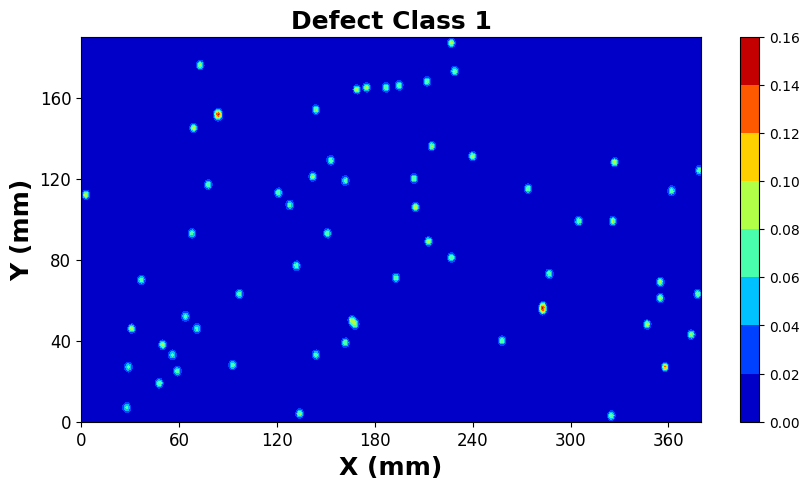

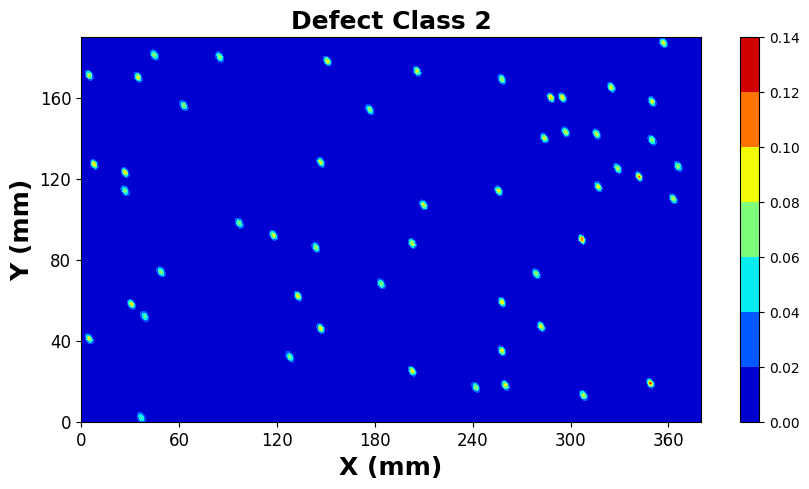

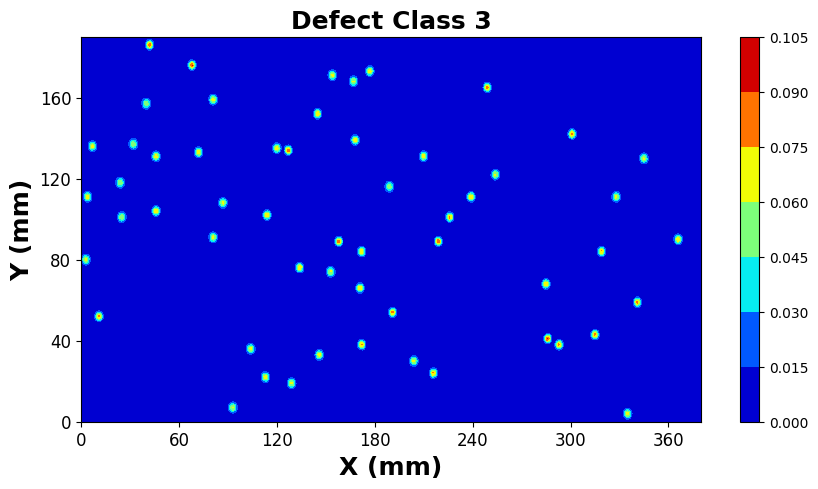

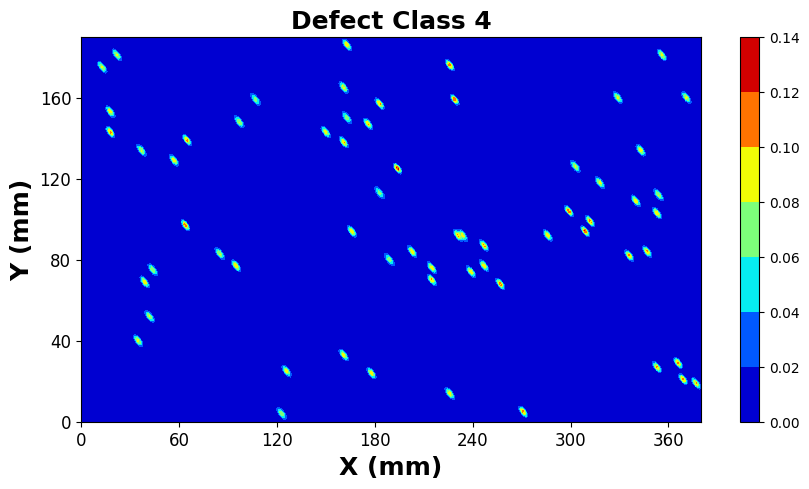

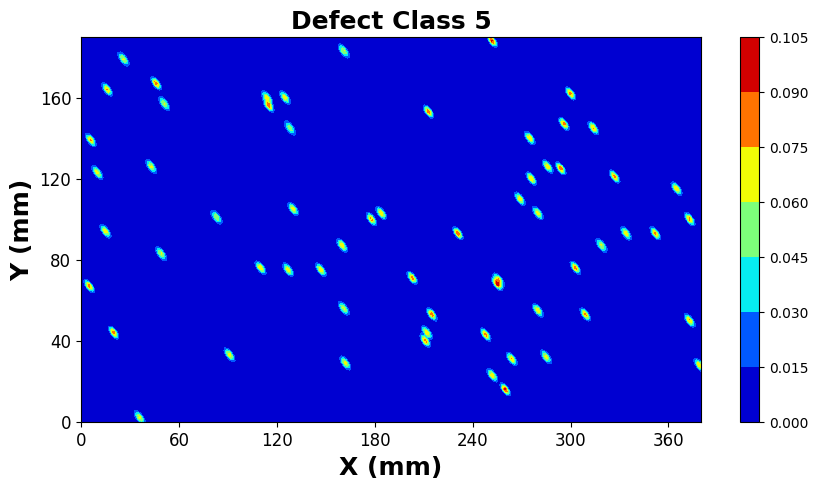

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

selected_class = 1
update_state = 0
for selected_class in [1, 2, 3, 4, 5]:
    fig = plt.figure(figsize=(10, 5))
    contourf = plt.contourf(instance.X, instance.Y, instance.Z_list[selected_class], zdir='z', cmap=cm.jet)
    plt.title("Defect Class " + str(selected_class), fontsize=18, fontweight='bold')
    plt.xlabel('X (mm)', fontsize=18, fontweight='bold')
    plt.ylabel('Y (mm)', fontsize=18, fontweight='bold')
    plt.yticks(np.linspace(0, 190, 20)[::4], fontsize=12)
    plt.xticks(np.linspace(0, 380, 20)[::3], fontsize=12)

    # Add a colorbar to the plot
    cbar = plt.colorbar(contourf)

    plt.savefig(str(instance.map_number) + '_' + str(selected_class) + '-' + str(update_state) + '.png', dpi=1200)
    plt.show()

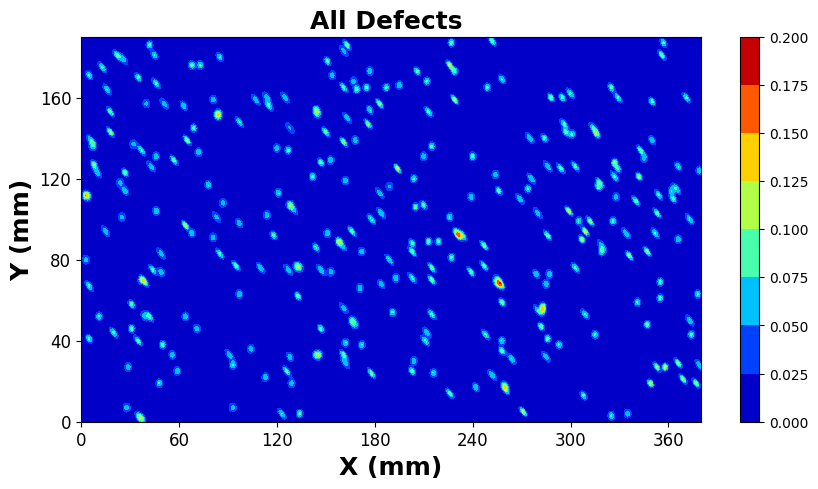

In [12]:
fig = plt.figure(figsize=(10, 5))
contourf = plt.contourf(instance.X, instance.Y, instance.Z_all, zdir='z', cmap=cm.jet)
plt.title("All Defects ", fontsize=18, fontweight='bold')
plt.xlabel('X (mm)', fontsize=18, fontweight='bold')
plt.ylabel('Y (mm)', fontsize=18, fontweight='bold')
plt.yticks(np.linspace(0, 190, 20)[::4], fontsize=12)
plt.xticks(np.linspace(0, 380, 20)[::3], fontsize=12)

# Add a colorbar to the plot
cbar = plt.colorbar(contourf)

plt.savefig(str(instance.map_number) + '_allDefects_' + str(update_state) + '.png', dpi=1200)
plt.show()

In [25]:
# Evalaute the quality of the map


fp = 0 # False Positive
correct = 0 # Correct guess
wrong = 0 # wrong guess

n = 0

time = 0

ref_map = instance.map_downsampled_updated
# ref_map = instance.map_downsampled
wrongs = []
real_downsampled_defects = 0
for i in range(len(instance.map_downsampled_real)):         # For all points in the map
    for j in range(len(instance.map_downsampled_real[0])):
        if instance.map_downsampled_real[i][j] > 0:         # If the point is a defect
            real_downsampled_defects += 1

            if instance.map_downsampled_real[i][j] == ref_map[i][j]:
                correct += 1    # We got it!
            else:
                wrong += 1      # Missed!!!!
                wrongs.append(instance.map_downsampled_real[i][j])
        else:
            if ref_map[i][j] > 0: # If its not a defect, it better not return a defect!
                fp +=1 # Returned defect for non-defect
        n += 1

print(n)

print("correct:", correct)
print("wrong:", wrong)
print("fp:", fp)
print("acc", correct/real_downsampled_defects)
print("overall_acc", (n-wrong-fp)/n)

72200
correct: 258
wrong: 22
fp: 15
acc 0.9214285714285714
overall_acc 0.9994875346260388


In [14]:
wrongs

[1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 2.0,
 5.0,
 2.0,
 2.0,
 1.0,
 2.0,
 3.0,
 3.0,
 2.0,
 2.0,
 1.0,
 1.0,
 4.0,
 1.0]

In [15]:
# Evaluate the lists

correct = 0
wrong = 0
fp = 0
for coords in instance.reeval_list:
    # print(coords)
    i = coords[0]
    j = coords[1]
    if instance.map_downsampled_real[i][j] == instance.map_downsampled[i][j]:
        correct += 1    # We got it!
    elif instance.map_downsampled_real[i][j] == 0:
        fp += 1 # Was supposed to be 0
    else: 
        # print(instance.map_downsampled_real[i][j])
        wrong += 1 # Was just wrong defect

print("correct:", correct)
print("wrong:", wrong)
print("fp:", fp)


correct = 0
wrong = 0
fp = 0
for coords in instance.reeval_list:
    # print(coords)
    i = coords[0]
    j = coords[1]
    if instance.map_downsampled_real[i][j] == instance.map_downsampled_updated[i][j]:
        correct += 1    # We got it!
    elif instance.map_downsampled_real[i][j] == 0:
        fp += 1 # Was supposed to be 0
    else: 
        # print(instance.map_downsampled_real[i][j])
        wrong += 1 # Was just wrong defect
print("---")
print("correct:", correct)
print("wrong:", wrong)
print("fp:", fp)

correct: 207
wrong: 0
fp: 35
---
correct: 228
wrong: 1
fp: 13


In [16]:
correction_time = np.random.normal(instance.defect_parameters["Mean_time"][1], instance.defect_parameters["Var_time"][1])
if correction_time < 0: correction_time += instance.defect_parameters["Mean_time"][1]


In [17]:
def perf_measure(y_actual, y_hat):

    '''

    Compute precision, recall, and F1 score between predicted and actual labels.

    '''

    # Generate a classification report with precision, recall, and F1 score

    # for each class. Store the report as a dictionary.

    report = classification_report(y_actual,y_hat, output_dict=True)

    precision = report['macro avg']['precision']

    recall = report['macro avg']['recall']

    f1 = report['macro avg']['f1-score']




    # Return the precision, recall, and F1 score as a tuple

    return precision, recall, f1

In [18]:
max_defect_chance = np.zeros(6)
for defect_class in range(len(instance.defect_parameters)):
    if defect_class > 0:
        print(defect_class)
        Y, X = np.meshgrid(np.linspace(0, 10, 11), np.linspace(0, 10, 11))
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        mu = np.array([5, 5])
        Sigma = np.array(   [[instance.defect_parameters['Sigma_xx'][int(defect_class)] , 
                            instance.defect_parameters['Sigma_yx'][int(defect_class)] ], 
                            [instance.defect_parameters['Sigma_xy'][int(defect_class)] ,  
                            instance.defect_parameters['Sigma_yy'][int(defect_class)] ]])
        Z = instance.multivariate_gaussian(pos, mu, Sigma)
        max_defect_chance[defect_class] = Z[5, 5]

max_defect_chance

1
2
3
4
5
6


IndexError: list index out of range

In [ ]:
def get_gd():

    Z_total = np.zeros_like(instance.map_downsampled)
    Z_all = np.zeros_like(instance.map_downsampled)
    defects = 0
    defect_list = []
    reeval_list = []
    discard_list = []
    for i in range(len(instance.map_downsampled)):
        for j in range(len(instance.map_downsampled[0])):
            # print(instance.map_downsampled[i][j])
            # if int(instance.map_downsampled[i][j]) > 4:
            #     print('passed')
            downsampled_defect = int(instance.map_downsampled[i][j])
            if downsampled_defect > 0:
                # print(i, j)
                ##Create the meshgrid
                #X, Y = np.meshgrid(np.linspace(0, 190, 190), np.linspace(0, 380, 380))
                Y, X = np.meshgrid(np.linspace(0, 190, 190), np.linspace(0, 380, 380))
                pos = np.empty(X.shape + (2,))
                pos[:, :, 0] = X
                pos[:, :, 1] = Y

                mu = np.array([i, j])
                Sigma = np.array(   [[instance.defect_parameters['Sigma_xx'][downsampled_defect]/instance.map_downsampled_observations[i][j] , 
                                    instance.defect_parameters['Sigma_yx'][downsampled_defect]/instance.map_downsampled_observations[i][j] ], 
                                    [instance.defect_parameters['Sigma_xy'][downsampled_defect]/instance.map_downsampled_observations[i][j] ,  
                                    instance.defect_parameters['Sigma_yy'][downsampled_defect]/instance.map_downsampled_observations[i][j]]])

                # print(Sigma)
                Z = instance.multivariate_gaussian(pos, mu, Sigma)
                Z_all = np.add(Z, Z_all)
                if Z[i][j]/max_defect_chance[downsampled_defect] > .5:
                    Z_total = np.add(Z, Z_total)
                    defect_list.append([i, j])
                    defects += 1
                elif Z[i][j]/max_defect_chance[downsampled_defect] > .25:
                    reeval_list.append([i, j])
                else:
                    discard_list.append([i, j])



    print(defects)
    return X, Y, Z_total, Z_all, defect_list, reeval_list, discard_list
    print(Z_total.shape, X.shape, Y.shape)
    # ax2.contourf(X, Y, Z_total, zdir='z', offset=0, cmap=cm.viridis)
    # # ax1.plot_surface(X, Y, Z_total, rstride=3, cstride=3, linewidth=1, antialiased=True,
    # #                 cmap=cm.viridis)



    # ax2.grid(False)
    # ax2.set_xticks([])
    # ax2.set_yticks([])
    # ax2.set_xlabel('X Location (meters)')
    # ax2.set_ylabel('Y Location (meters)')
    # fig.savefig('Likelihood' + '.png', bbox_inches='tight', dpi=300)
    # plt.show()

    

X, Y, Z_total, Z_all, defect_list, reeval_list, discard_list = get_gd()

59


In [ ]:
### Reobserve from location

for coords in reeval_list:
    bound = np.zeros(shape=(380, 190))
    bound_obs = np.zeros(shape=(380, 190))
    span = np.linspace(-5, 5, 11)[0:10]/10
    span_classed = np.zeros(shape=(11, 11))

    span_x = span + coords[0]
    span_y = span + coords[1]
    span_obs = np.zeros(6)
    for t in range(10):
        for x in range(len(span_x)):
                for y in range(len(span_y)):
                    # Try the key, if failed pass
                    try:
                        state = instance.map_classed[(span_x[x], span_y[y])]
                        distance = np.sqrt((coords[0]-span_x[x])**2 + (coords[1]-span_y[y])**2)
                        val = random.random()
                        if val < instance.observation_chance - (distance * (.28/.5)):
                            state_obs = state[2]
                        else:
                            state_obs = random.choices(instance.defect_parameters['Class'])[0]

                        span_obs[state_obs] += 1
                    except:
                        pass

    
    max_index = np.where(span_obs == np.max(span_obs))
    #print(max_index[0][0])
    # print(max_index, instance.map_downsampled[coords[0]][coords[1]])
    instance.map_downsampled[coords[0]][coords[1]] = max_index[0][0]

In [ ]:
def perf_measurement_list(reference_list):
    p = 0
    f = 0

    for defect in discard_list:
        guessed_class = instance.map_downsampled[defect[0]][defect[1]] 
        real_class = instance.map_downsampled_real[defect[0]][defect[1]]
        if guessed_class == real_class:
            p +=1 
        else:
            # print(guessed_class, real_class)
            f +=1

    return p, f

def perf_comparison(arr):
    
    return 

304

In [ ]:
real_defect_list = []
count = 0
for i in range(len(instance.map_downsampled_real)):
    for j in range(len(instance.map_downsampled_real[0])):
        if instance.map_downsampled_real[i][j] > 0:
            real_defect_list.append([i, j])
            count += 1
count

282

In [ ]:
p = 0
f = 0

for defect in discard_list:
    guessed_class = instance.map_downsampled[defect[0]][defect[1]] 
    real_class = instance.map_downsampled_real[defect[0]][defect[1]]
    if guessed_class == real_class:
        p +=1 
    else:
        # print(guessed_class, real_class)
        f +=1

print(p, f)


0 304


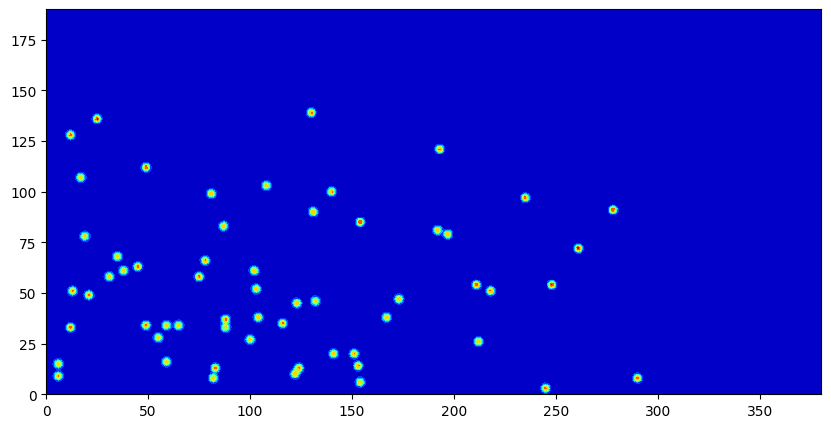

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.contourf(X, Y, Z_total, zdir='z', cmap=cm.jet)
plt.savefig('med_defect_91_defects' + '.png', dpi=1200)
plt.show()

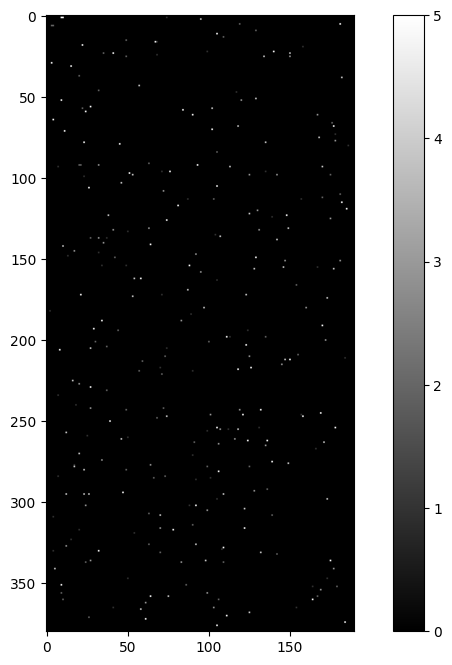

In [ ]:

# Create a random 190x200 numpy array with values from 1-5
# array = np.random.randint(low=1, high=6, size=(190, 200))

# Display the array as an image
fig = plt.figure(figsize=(10, 8))
plt.imshow(instance.map_downsampled, cmap='gray', vmin=0, vmax=5)
plt.colorbar()
plt.show()
fig.savefig('obs_map.png', dpi=1200)

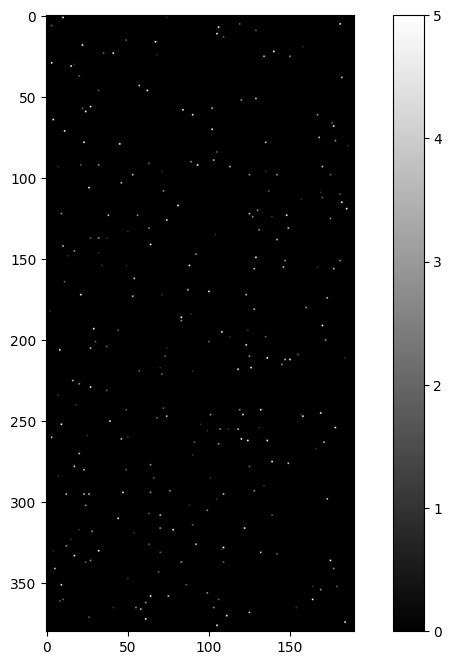

In [ ]:

# Create a random 190x200 numpy array with values from 1-5
# array = np.random.randint(low=1, high=6, size=(190, 200))

# Display the array as an image
fig = plt.figure(figsize=(10, 8))
plt.imshow(instance.map_downsampled_real, cmap='gray', vmin=0, vmax=5)
plt.colorbar()
plt.show()
fig.savefig('real_map.png', dpi=1200)